In [310]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [311]:
import os

# List files inside the scripts folder
print(os.listdir("scripts"))


['deploy.py', 'extract_data.py', 'ingest_live_gee.py', 'ingest_live_nlp.py', 'ingest_live_wpdx.py', 'merge_data.py', 'prepare_data.py', 'train_nlp.py', 'train_xgb.py', '__init__.py', '__pycache__']


## Step 1: Data Loading and Initial Exploration
To begin our NLP project, we first loaded the dataset which contains humanitarian assessment reports, each associated with a severity label. Our aim is to predict the severity of humanitarian issues based on the textual content of these reports.

**Key Steps in Data Loading:**
Loaded the dataset using Pandas.

Displayed basic information: column names, data types, and sample records.

Verified the presence of essential columns for NLP and modeling:

excerpt: the main text field describing events.

severity: the target label, with categories like "Critical Issue", "Severe Issue", "Minor Issue", etc.

lang: ensured all records are in English ('en').

Checked for null or missing values in the key columns.

In [312]:
import pandas as pd

df = pd.read_csv('data/processed/nlp.csv')
print(f"Shape: {df.shape}")
df.head()


Shape: (76466, 24)


,Unnamed: 0,entry_id,lead_id,lang,n_tokens,project_title,created_at,document,source_title,author_title,...,pillars_2d,subpillars_1d,subpillars_2d,displaced,non_displaced,affected,severity,age,gender,specific_needs_groups
0,0,199921,44304,en,145,IMMAP/DFS Burkina Faso,2020-11-26 10:42:14.523264+00:00,Unknown,United Nations High Commissioner for Refugees,Unknown,...,[],['Displacement->Type/Numbers/Movements'],[],['Idp'],[],['Displaced'],[],[],[],[]
1,1,293791,52163,en,480,IMMAP/DFS Burkina Faso,2021-03-29 06:53:04.456578+00:00,https://allafrica.com/stories/202103160182.html,AllAfrica,Unknown,...,[],"['Context->Environment', 'Context->Economy']",[],[],[],[],[],[],[],[]
2,2,169536,40366,en,879,IMMAP/DFS Burkina Faso,2020-10-06 21:23:24.022536+00:00,Unknown,Reliefweb,Unknown,...,['At Risk'],"['Casualties->Dead', 'Context->Security & Stab...",['At Risk->Risk And Vulnerabilities'],[],[],[],[],[],[],[]
3,3,169537,40366,en,642,IMMAP/DFS Burkina Faso,2020-10-06 21:23:25.409843+00:00,Unknown,Reliefweb,Unknown,...,[],"['Displacement->Type/Numbers/Movements', 'Disp...",[],[],[],['Displaced'],[],"['<18 Years', '18-59 Years Old']","['All', 'Female']",[]
4,4,155848,38493,en,600,IMMAP/DFS Burkina Faso,2020-09-08 12:42:54.252017+00:00,Unknown,UNHCR Portal,Unknown,...,['Capacities & Response'],['Information And Communication->Communication...,['Capacities & Response->International Response'],['Idp'],['Host'],"['Non Displaced', 'Displaced']",[],[],[],[]


In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76466 entries, 0 to 76465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             76466 non-null  int64 
 1   entry_id               76466 non-null  int64 
 2   lead_id                76466 non-null  int64 
 3   lang                   76466 non-null  object
 4   n_tokens               76466 non-null  int64 
 5   project_title          76466 non-null  object
 6   created_at             76466 non-null  object
 7   document               76466 non-null  object
 8   source_title           76466 non-null  object
 9   author_title           76466 non-null  object
 10  excerpt                76466 non-null  object
 11  geo_location           76466 non-null  object
 12  sectors                76466 non-null  object
 13  pillars_1d             76466 non-null  object
 14  pillars_2d             76466 non-null  object
 15  subpillars_1d      

In [314]:
df.isnull().sum()

Unnamed: 0               0
entry_id                 0
lead_id                  0
lang                     0
n_tokens                 0
project_title            0
created_at               0
document                 0
source_title             0
author_title             0
excerpt                  0
geo_location             0
sectors                  0
pillars_1d               0
pillars_2d               0
subpillars_1d            0
subpillars_2d            0
displaced                0
non_displaced            0
affected                 0
severity                 0
age                      0
gender                   0
specific_needs_groups    0
dtype: int64

In [315]:
# Check the first few rows
df.sample(5)

# Show column names
print("Columns:", df.columns.tolist())

# Let's look at class distribution (assuming label column is named 'label')
if 'label' in df.columns or 'target' in df.columns:
    target_col = 'label' if 'label' in df.columns else 'target'
    print(df[target_col].value_counts())
else:
    print("Target column not found. Please confirm the label column name.")


Columns: ['Unnamed: 0', 'entry_id', 'lead_id', 'lang', 'n_tokens', 'project_title', 'created_at', 'document', 'source_title', 'author_title', 'excerpt', 'geo_location', 'sectors', 'pillars_1d', 'pillars_2d', 'subpillars_1d', 'subpillars_2d', 'displaced', 'non_displaced', 'affected', 'severity', 'age', 'gender', 'specific_needs_groups']
Target column not found. Please confirm the label column name.


In [316]:
print("All column names:")
print(df.columns.tolist())

All column names:
['Unnamed: 0', 'entry_id', 'lead_id', 'lang', 'n_tokens', 'project_title', 'created_at', 'document', 'source_title', 'author_title', 'excerpt', 'geo_location', 'sectors', 'pillars_1d', 'pillars_2d', 'subpillars_1d', 'subpillars_2d', 'displaced', 'non_displaced', 'affected', 'severity', 'age', 'gender', 'specific_needs_groups']


## Step 2: Feature Engineering
To prepare the data for natural language modeling, we engineered and extracted several features from the text.

### 2.1: Word Count Feature
We added a word_count column to capture how long each text excerpt is. This can help identify if length correlates with severity.

In [317]:
# Add the excerpt_length column
df['excerpt_length'] = df['excerpt'].fillna('').apply(len)

print(df.columns)
df.head()

Index(['Unnamed: 0', 'entry_id', 'lead_id', 'lang', 'n_tokens',
       'project_title', 'created_at', 'document', 'source_title',
       'author_title', 'excerpt', 'geo_location', 'sectors', 'pillars_1d',
       'pillars_2d', 'subpillars_1d', 'subpillars_2d', 'displaced',
       'non_displaced', 'affected', 'severity', 'age', 'gender',
       'specific_needs_groups', 'excerpt_length'],
      dtype='object')


,Unnamed: 0,entry_id,lead_id,lang,n_tokens,project_title,created_at,document,source_title,author_title,...,subpillars_1d,subpillars_2d,displaced,non_displaced,affected,severity,age,gender,specific_needs_groups,excerpt_length
0,0,199921,44304,en,145,IMMAP/DFS Burkina Faso,2020-11-26 10:42:14.523264+00:00,Unknown,United Nations High Commissioner for Refugees,Unknown,...,['Displacement->Type/Numbers/Movements'],[],['Idp'],[],['Displaced'],[],[],[],[],91
1,1,293791,52163,en,480,IMMAP/DFS Burkina Faso,2021-03-29 06:53:04.456578+00:00,https://allafrica.com/stories/202103160182.html,AllAfrica,Unknown,...,"['Context->Environment', 'Context->Economy']",[],[],[],[],[],[],[],[],288
2,2,169536,40366,en,879,IMMAP/DFS Burkina Faso,2020-10-06 21:23:24.022536+00:00,Unknown,Reliefweb,Unknown,...,"['Casualties->Dead', 'Context->Security & Stab...",['At Risk->Risk And Vulnerabilities'],[],[],[],[],[],[],[],540
3,3,169537,40366,en,642,IMMAP/DFS Burkina Faso,2020-10-06 21:23:25.409843+00:00,Unknown,Reliefweb,Unknown,...,"['Displacement->Type/Numbers/Movements', 'Disp...",[],[],[],['Displaced'],[],"['<18 Years', '18-59 Years Old']","['All', 'Female']",[],421
4,4,155848,38493,en,600,IMMAP/DFS Burkina Faso,2020-09-08 12:42:54.252017+00:00,Unknown,UNHCR Portal,Unknown,...,['Information And Communication->Communication...,['Capacities & Response->International Response'],['Idp'],['Host'],"['Non Displaced', 'Displaced']",[],[],[],[],379


In [318]:
df['excerpt'].sample(5, random_state=1).values

array(['ETT assessments iden�fied the following movement triggers: voluntary reloca�on (20%), improved security (11%), involuntary reloca�on (1%), ongoing conflict (5%), military opera�on (6%) and poor living condi�ons (57%).',
       '[3rd March 2021, Bangladesh] The total caseload rose to 547,930 with the 614 new cases, according to the Directorate General of Health Services (DGHS).',
       'In Uruzgan province, clashes between Afghan National Security Forces (ANSF) and a non-state armed group (NSAG) continued in Dehrawud, Gizab and Tirinkot districts.',
       'As of 27 May 2019, a total of 9,432 individuals from Sabon Gari and Azur communities (on the border between Damboa and Biu LGAs) were forcibly displaced by military authorities to Damboa town. Needs assessments confirmed that 8,005 people including highly vulnerable individuals are staying in open areas without shelter . The provision of shelter and WASH facilities for new arrivals remains complicated until aid agencies are 

In [319]:
# Word Count per Excerpt
df['word_count'] = df['excerpt'].apply(lambda x: len(str(x).split()))
df[['excerpt', 'word_count']].sample(5, random_state=2)

,excerpt,word_count
2194,"A total of 1,209 actors – including local auth...",52
48645,[IMMEDIATE NEEDS:] Training of Health Personne...,12
45291,"Assessment teams identified 1,032 people displ...",22
3323,"[31st Jan 2021, Bangladesh] With the fresh one...",41
74806,"Migration flows are likely to fall, but the st...",107


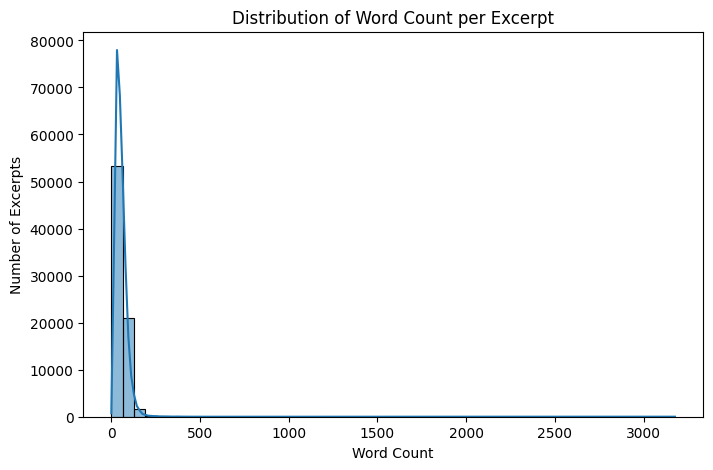

In [320]:
# Plot Word Count Distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribution of Word Count per Excerpt')
plt.xlabel('Word Count')
plt.ylabel('Number of Excerpts')
plt.show()


In [321]:
# Check Language Column
df['lang'].value_counts()

lang
en    76466
Name: count, dtype: int64

### 2.2 Target Distribution

Before training any models, we explored the distribution of the target column `severity` to assess class imbalance.

Understanding this distribution is critical:
- Helps detect whether the dataset is skewed.
- Informs the choice of evaluation metrics (e.g., precision-recall if imbalance is high).
- Guides model tuning decisions like `class_weight`.

We found that most entries fall under:
- **"Severe Issue"**
- **"Issue Of Concern"**
while only a few are labeled as:
- **"No Issue"** or **"Minor Issue"**


In [322]:
# Check how many documents are usable
print("Number of usable text entries:", df['document'].notna().sum())

# Check severity label distribution
print("\nSeverity value counts:")
df['severity'].explode().value_counts(dropna=False)


Number of usable text entries: 76466

Severity value counts:


severity
[]                      57680
['Severe Issue']        11037
['Issue Of Concern']     4786
['Critical Issue']       1936
['No Issue']              578
['Minor Issue']           449
Name: count, dtype: int64

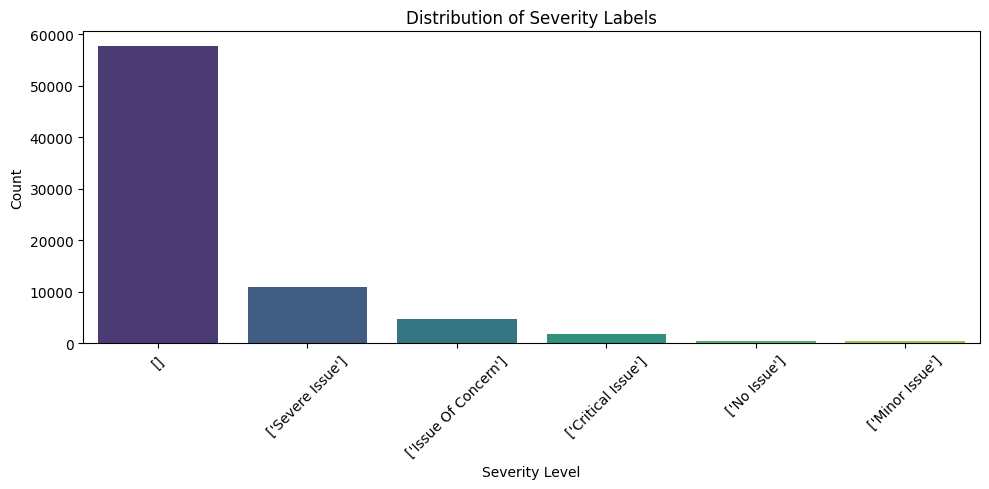

In [323]:
# Prepare the data as a DataFrame for better control
severity_counts = df['severity'].value_counts()
severity_df = severity_counts.reset_index()
severity_df.columns = ['severity', 'count']

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=severity_df, x='severity', y='count', hue='severity', palette='viridis', dodge=False, legend=False)
plt.title("Distribution of Severity Labels")
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This bar plot shows how many samples exist per severity category.

**Why this is important:**
Knowing the balance or imbalance between classes helps determine:

Whether we need to rebalance the dataset (e.g., through oversampling or class weighting).

How reliable accuracy will be as a metric.

`Class Imbalance:` The dataset is highly imbalanced. Over 76% of the records have no severity label at all (missing/empty). Only a small portion represents high severity like Critical or Severe issues.



#### **2.2.1 Target Column Preparation: `severity`****

Before we clean our text data, it's important to ensure the target column is ready for modeling. This includes:

- Removing rows with missing target values
- Exploring the class distribution to check for imbalance
- Encoding categorical target labels into numerical form

This step ensures our model will learn from clean and consistent label data.


In [324]:
# Check for missing severity labels
missing_targets = df['severity'].isna().sum()
print(f"Missing severity labels: {missing_targets}")

# Drop rows with missing severity
df = df.dropna(subset=['severity'])

# Confirm cleanup
print(f"Remaining samples: {len(df)}")

Missing severity labels: 0
Remaining samples: 76466


In [325]:
from sklearn.preprocessing import LabelEncoder

# Encode severity labels into integers
label_encoder = LabelEncoder()
df['severity_encoded'] = label_encoder.fit_transform(df['severity'])

# Preview encoded values
df[['severity', 'severity_encoded']].drop_duplicates()

,severity,severity_encoded
0,[],5
5,['Severe Issue'],4
8,['Critical Issue'],0
34,['Issue Of Concern'],1
561,['Minor Issue'],2
61914,['No Issue'],3


In [326]:
df = pd.read_csv('data/processed/nlp.csv')

In [328]:
import ast

# Safe conversion function
def robust_severity_parser(val):
    if isinstance(val, list):
        return val  # Already a list
    if isinstance(val, str):
        try:
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list):
                return parsed
        except:
            return [val]  # Wrap single string in list
    return []

# Apply to column
df['severity'] = df['severity'].apply(robust_severity_parser)

# Remove empty lists
df = df[df['severity'].apply(lambda x: x != [])].reset_index(drop=True)

# Check result
print(df['severity'].head())


0      [Severe Issue]
1      [Severe Issue]
2    [Critical Issue]
3      [Severe Issue]
4      [Severe Issue]
Name: severity, dtype: object


In [330]:
df['severity'].apply(lambda x: x[0]).value_counts()


severity
Severe Issue        11037
Issue Of Concern     4786
Critical Issue       1936
No Issue              578
Minor Issue           449
Name: count, dtype: int64

In [339]:
import pickle

# Saving the encoder for later use
with open('severity_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)


In [340]:
for i, count in enumerate(severity_counts.values):
    plt.text(i, count + 50, f'{count}', ha='center', va='bottom')


MemoryError: bad allocation

<Figure size 640x480 with 1 Axes>